{danger} Caution!
Do not change the code below.

In [2]:
import data.fusion_utils as utils

from scipy.sparse import spdiags
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np

In [3]:
data = np.load('data/PTO_Trilayer_dataset.npz')
# Define element names and their atomic weights
elem_names=['Sc', 'Dy', 'O']
elem_weights=[21,66,8]
# Parse elastic HAADF data and inelastic chemical maps based on element index from line above
HAADF = data['HAADF']
xx = np.array([],dtype=np.float32)
for ee in elem_names:

	# Read Chemical Map for Element "ee"
	chemMap = data[ee]

    # Check if chemMap has the same dimensions as HAADF
	if chemMap.shape != HAADF.shape:
		raise ValueError(f"The dimensions of {ee} chemical map do not match HAADF dimensions.")
	
	# Set Noise Floor to Zero and Normalize Chemical Maps
	chemMap -= np.min(chemMap); chemMap /= np.max(chemMap)

	# Concatenate Chemical Map to Variable of Interest
	xx = np.concatenate([xx,chemMap.flatten()])

In [4]:
# Make Copy of Raw Measurements for Poisson Maximum Likelihood Term 
xx0 = xx.copy()

# Incoherent linear imaging for elastic scattering scales with atomic number Z raised to γ  ∈ [1.4, 2]
gamma = 1.6 

# Image Dimensions
(nx, ny) = chemMap.shape; nPix = nx * ny
nz = len(elem_names)

# C++ TV Min Regularizers
reg = utils.tvlib(nx,ny)

# Data Subtraction and Normalization 
HAADF -= np.min(HAADF); HAADF /= np.max(HAADF)
HAADF=HAADF.flatten()

# Create Summation Matrix
A = utils.create_weighted_measurement_matrix(nx,ny,nz,elem_weights,gamma,1)

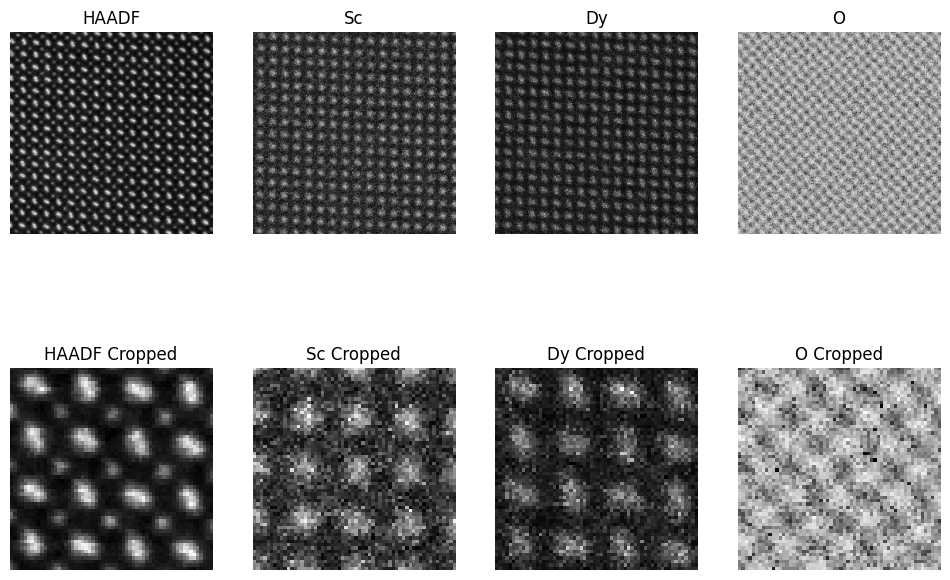

In [5]:
fig, ax = plt.subplots(2,len(elem_names)+1,figsize=(12,8))
ax = ax.flatten()
ax[0].imshow(HAADF.reshape(nx,ny),cmap='gray'); ax[0].set_title('HAADF'); ax[0].axis('off')
ax[1+len(elem_names)].imshow(HAADF.reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[1+len(elem_names)].set_title('HAADF Cropped'); ax[1+len(elem_names)].axis('off')

for ii in range(len(elem_names)):
    ax[ii+1].imshow(xx0[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny),cmap='gray'); ax[ii+1].set_title(elem_names[ii]); ax[ii+1].axis('off')
    ax[ii+2+len(elem_names)].imshow(xx0[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[ii+2+len(elem_names)].set_title(elem_names[ii]+' Cropped'); ax[ii+2+len(elem_names)].axis('off')
plt.show()

In [6]:
# Convergence Parameters
lambdaHAADF = 1/nz # Do not modify this
lambdaChem = 0.08
lambdaTV = 0.15; #Typically between 0.001 and 1
nIter = 30 # Typically 10-15 will suffice
bkg = 2.4e-1

# FGP TV Parameters
regularize = True; nIter_TV = 3; 

In [7]:
# xx represents the flattened 1D elastic maps we are trying to improve via the cost function
xx = xx0.copy()

# Auxiliary Functions for measuring the cost functions
lsqFun = lambda inData : 0.5 * np.linalg.norm(A.dot(inData**gamma) - HAADF) **2
poissonFun = lambda inData : np.sum(xx0 * np.log(inData + 1e-8) - inData)

# Main Loop

# Initialize the three cost functions components 
costHAADF = np.zeros(nIter,dtype=np.float32); costChem = np.zeros(nIter, dtype=np.float32); costTV = np.zeros(nIter, dtype=np.float32);

for kk in tqdm(range(nIter)):
	# Solve for the first two optimization functions $\Psi_1$ and $\Psi_2$
	xx -=  gamma * spdiags(xx**(gamma - 1), [0], nz*nx*ny, nz*nx*ny) * lambdaHAADF * A.transpose() * (A.dot(xx**gamma) - HAADF) + lambdaChem * (1 - xx0 / (xx + bkg))

	# Enforce positivity constraint
	xx[xx<0] = 0

	# FGP Regularization if turned on
	if regularize:
		for zz in range(nz):
			xx[zz*nPix:(zz+1)*nPix] = reg.fgp_tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny), lambdaTV, nIter_TV).flatten()

			# Measure TV Cost Function
			costTV[kk] += reg.tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny) )
			
	# Measure $\Psi_1$ and $\Psi_2$ Cost Functions
	costHAADF[kk] = lsqFun(xx); costChem[kk] = poissonFun(xx)

100%|██████████| 30/30 [00:00<00:00, 52.17it/s]


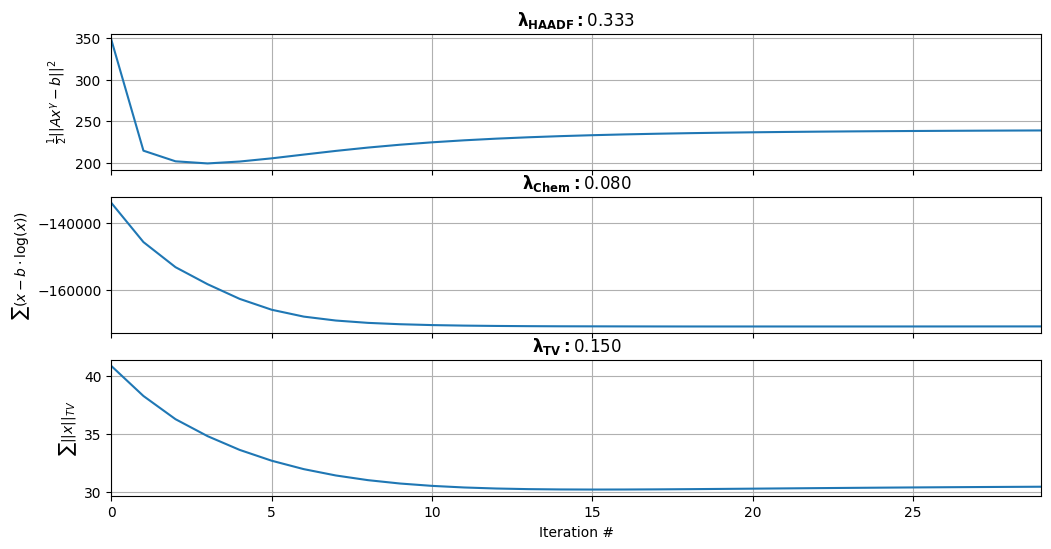

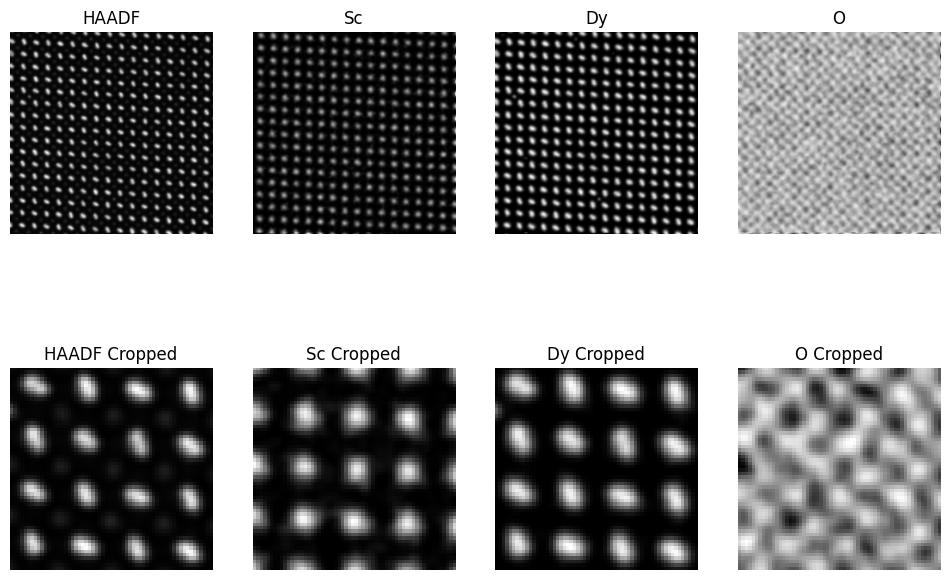

In [8]:
# Display Cost Functions and Descent Parameters
utils.plot_convergence(costHAADF, lambdaHAADF, costChem, lambdaChem, costTV, lambdaTV)
# Show Reconstructed Signal
fig, ax = plt.subplots(2,len(elem_names)+1,figsize=(12,8))
ax = ax.flatten()
ax[0].imshow((A.dot(xx**gamma)).reshape(nx,ny),cmap='gray'); ax[0].set_title('HAADF'); ax[0].axis('off')
ax[1+len(elem_names)].imshow((A.dot(xx**gamma)).reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[1+len(elem_names)].set_title('HAADF Cropped'); ax[1+len(elem_names)].axis('off')

for ii in range(len(elem_names)):
    ax[ii+1].imshow(xx[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny),cmap='gray'); ax[ii+1].set_title(elem_names[ii]); ax[ii+1].axis('off')
    ax[ii+2+len(elem_names)].imshow(xx[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[ii+2+len(elem_names)].set_title(elem_names[ii]+' Cropped'); ax[ii+2+len(elem_names)].axis('off')
plt.show()

In [9]:
save_folder_name='test'
utils.save_data(save_folder_name, xx0, xx, HAADF, A.dot(xx**gamma), elem_names, nx, ny, costHAADF, costChem, costTV, lambdaHAADF, lambdaChem, lambdaTV, gamma)

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'test/Fused_Reconstruction.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)